In [1]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd

import ccf_analysis_utils

In [2]:
def get_region_tree(df, name):
    return df[df['region'] == name]['tree'].values[0]

def get_all_subregion_annotations_from_tree(df, tree):
    return df[df['tree'].str.contains(tree)]
              
def get_all_subregion_annotations_from_name(df, name):
    tree = get_region_tree(df, name)
    return get_all_subregion_annotations_from_tree(df, tree)

def get_n_layer_down_subregions_from_tree(df, tree, n):
    return df[df['tree'].str.contains(tree) & (df['tree'].str.count('/') == (tree.count('/')+n))]

def get_n_layer_down_subregions_from_name(df, name, n):
    tree = get_region_tree(df, name)
    return get_n_layer_down_subregions_from_tree(df, tree, n)

def sum_up_neurons(annotations_list, subregion_annotations):
    n = 0
    for subreg in subregion_annotations:
        n += np.sum(annotations_list == subreg)
    return n

In [3]:
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

mat = spio.loadmat('forShaul.mat', squeeze_me = True)
simple_r2 = spio.loadmat('simple_r2.mat', squeeze_me = True)
r2 = simple_r2['simple_r2']
thalamus_mat = spio.loadmat('thalamus_subregions.mat', squeeze_me = True)

df.head()

,id,region,tree
0,997,root,/997/
1,8,Basic cell groups and regions,/997/8/
2,567,Cerebrum,/997/8/567/
3,688,Cerebral cortex,/997/8/567/688/
4,695,Cortical plate,/997/8/567/688/695/


In [4]:
Midbrain_subregions = get_n_layer_down_subregions_from_name(df, 'Striatum', 1)['region'].values
Midbrain_subregions_annotations = {}
for subregion in Midbrain_subregions:
    Midbrain_subregions_annotations[subregion] = get_all_subregion_annotations_from_name(df, subregion)['region'].values

Midbrain_subregions_annotations

{'Striatum dorsal region': array(['Striatum dorsal region', 'Caudoputamen'], dtype=object),
 'Striatum ventral region': array(['Striatum ventral region', 'Nucleus accumbens',
        'Fundus of striatum', 'Olfactory tubercle', 'Islands of Calleja',
        'Major island of Calleja', 'Olfactory tubercle, layers 1-3',
        'Olfactory tubercle, molecular layer',
        'Olfactory tubercle, pyramidal layer',
        'Olfactory tubercle, polymorph layer'], dtype=object),
 'Lateral septal complex': array(['Lateral septal complex', 'Lateral septal nucleus',
        'Lateral septal nucleus, caudal (caudodorsal) part',
        'Lateral septal nucleus, rostral (rostroventral) part',
        'Lateral septal nucleus, ventral part', 'Septofimbrial nucleus',
        'Septohippocampal nucleus'], dtype=object),
 'Striatum-like amygdalar nuclei': array(['Striatum-like amygdalar nuclei', 'Anterior amygdalar area',
        'Bed nucleus of the accessory olfactory tract',
        'Central amygdalar nuc

In [5]:
neuron_count = {}

for subreg, subreg_annots in Midbrain_subregions_annotations.items():
    neuron_count[subreg] = sum_up_neurons(mat['annotation'], subreg_annots)

for k,v in neuron_count.items():
    print(k,v)

Striatum dorsal region 4145
Striatum ventral region 120
Lateral septal complex 0
Striatum-like amygdalar nuclei 384


In [6]:
def get_neuron_inds_for_subregions(annotations_list, subregion_annotations):
    inds = {}
    for subreg,subreg_annots in subregion_annotations.items():
        inds[subreg] = []
        for subreg_annot in subreg_annots:
            inds[subreg].append(np.where(annotations_list == subreg_annot)[0])
        inds[subreg] = np.concatenate(inds[subreg])
    return inds

In [7]:
inds = get_neuron_inds_for_subregions(mat['annotation'], Midbrain_subregions_annotations)
inds

{'Striatum dorsal region': array([ 2859,  2860,  2861, ..., 34099, 34100, 34101]),
 'Striatum ventral region': array([11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557,
        11558, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11568,
        11569, 19997, 20033, 20034, 20035, 20036, 20037, 20038, 20039,
        20040, 20041, 20042, 34103, 34104, 15105, 15107, 15108, 15109,
        15110, 15111, 15178, 15179, 15190, 15191, 15192, 15193, 15194,
        15195, 15266, 15837, 15838, 15839, 15840, 15841, 15873, 15876,
        16346, 16357, 16358, 16359, 16360, 16361, 16362, 16363, 16364,
        16365, 16366, 16381, 16385, 16386, 16387, 16445, 16467, 16468,
        16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477,
        16498, 16499, 16500, 16501, 21282, 21283, 21360, 21376, 21377,
        21378, 21379, 21380, 21381, 21382, 21383, 21384, 21385, 21386,
        21436, 21437, 21450, 22789, 22790, 22791, 22792, 22793, 22794,
        22795, 22796, 22797, 22798, 22

/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/kurgyis/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


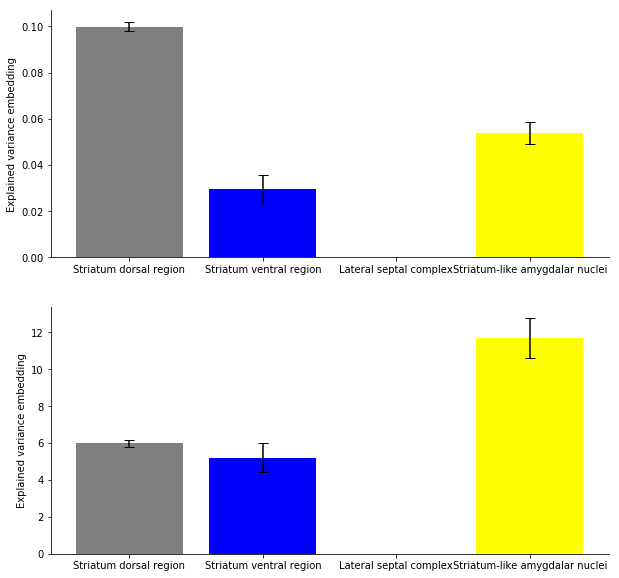

In [9]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)
cc = ['grey','blue','green','yellow']

m = np.zeros(len(Midbrain_subregions))
sem = np.zeros(len(Midbrain_subregions))
for idx, sub_region_label in enumerate(Midbrain_subregions):
    m[idx] = np.mean(r2[inds[Midbrain_subregions[idx]]])
    sem[idx] = np.std(r2[inds[Midbrain_subregions[idx]]]) \
        /np.sqrt(r2[inds[Midbrain_subregions[idx]]].shape[0])

ax_bar.bar(np.arange(0,len(Midbrain_subregions)),m, color = cc, \
           yerr=sem, align='center', ecolor='black', capsize=5)
_ = ax_bar.set_xticks(np.arange(0,len(Midbrain_subregions)))
_ = ax_bar.set_xticklabels(Midbrain_subregions)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
_ = ax_bar.set_ylabel('Explained variance embedding')

ax_bar = f.add_subplot(2,1,2)

m_fr = np.zeros(len(Midbrain_subregions))
sem = np.zeros(len(Midbrain_subregions))
for idx, sub_region_label in enumerate(Midbrain_subregions):
    m_fr[idx] = np.mean(mat['fr'][inds[Midbrain_subregions[idx]]])
    sem[idx] = np.std(mat['fr'][inds[Midbrain_subregions[idx]]]) \
        /np.sqrt(mat['fr'][inds[Midbrain_subregions[idx]]].shape[0])

ax_bar.bar(np.arange(0,len(Midbrain_subregions)),m_fr, color = cc, \
           yerr=sem, align='center', ecolor='black', capsize=5)
_ = ax_bar.set_xticks(np.arange(0,len(Midbrain_subregions)))
_ = ax_bar.set_xticklabels(Midbrain_subregions)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
_ = ax_bar.set_ylabel('Explained variance embedding')

In [10]:
def add_color_map_plot(ax, group_list, thalamus_mat, data_to_map, coords, \
	data_mask_thresh, clim_vals, three_d_flag, plot_dict):
	''' In this version the expectation is that coords will be given
		specifically to be used (i.e., for coronal dims 1 2 of CCF coords).
		I am a little confused with thalamus mat. I believe it is just the indices.
		I should replace it with a list of indices per subregion. Not the whole
		mat
	'''
	ind = 0
	for sr in group_list:
		colors = data_to_map[thalamus_mat[sr]]
		#print(colors.shape)
		cur_neuron_coords = coords[thalamus_mat[sr]]
		mask = data_to_map[thalamus_mat[sr]] > data_mask_thresh
		colors = colors[mask]
		use_coords = cur_neuron_coords[mask,:]
		if three_d_flag:
			use_cm = plt.get_cmap('Blues')
			scatter_obj = ax.scatter(use_coords[:,0], use_coords[:,1],use_coords[:,2], \
				s=5, c = colors, cmap = use_cm, vmin = clim_vals[0], vmax = clim_vals[1])
		else:
			# use_cm = 'inferno'
			use_cm = plt.get_cmap('Blues')
			scatter_obj = ax.scatter(use_coords[:,0], use_coords[:,1], \
				s=10, c = colors, cmap = use_cm, vmin = clim_vals[0], vmax = clim_vals[1])
				# removed: clim = clim_vals
		ind+=1
	#ax.set_xlabel('ML (right-left)')
	#ax.set_ylabel('DV (up-down)')
	ax.set_xlabel(plot_dict['axis_zero_label'])
	ax.set_ylabel(plot_dict['axis_one_label'])
	
	if three_d_flag:
		#ax.set_xlim(plot_dict['xlim'])
		#ax.set_ylim(plot_dict['ylim'])
		#ax.set_zlim(plot_dict['zlim'])

		#ax.set_zlabel('AP (front-back)')
		#ax.set_xlim(-3000,3000)
		#ax.set_ylim(3000,8000)
		#ax.set_zlim(0,2500)

		ax.set_xlim(plot_dict['xlim'])
		ax.set_ylim(plot_dict['ylim'])
		ax.set_zlim(plot_dict['zlim'])

		ax.set_zlabel('AP (front-back)')
	else:
		#ax.set_xlim(plot_dict['xlim'])
		#ax.set_ylim(plot_dict['ylim'])
		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
	return scatter_obj

In [21]:
plot_dict = dict()
plot_dict['xlim'] = (0, 6500)
plot_dict['ylim'] = (500,3500)
plot_dict['zlim'] = (500,3000)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

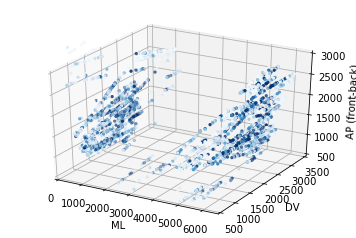

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

add_color_map_plot(ax, Midbrain_subregions, inds, r2, mat['coord'], \
                    0, (0.,0.2), True, plot_dict)

In [23]:
Midbrain_subregions_annotations[Midbrain_subregions[0]]

array(['Striatum dorsal region', 'Caudoputamen'], dtype=object)

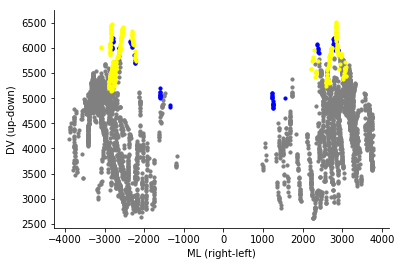

In [24]:
fig = plt.figure()
three_d_flag = False
ax = fig.add_subplot(111)
ccf_analysis_utils.add_solid_color_plot(ax, Midbrain_subregions, inds, r2, \
                     mat['coord'][:,0:2], 0, \
                     cc, three_d_flag)

## Look at what Nuo suggested:
There are many different nuclei. I’m not sure there is another intermediate level after Midbrain motor. Within MBmot, the ones I know might be good to look at are:
- SNr
- MRN
- SCm
- PAG
- CUN
- RN

A couple in the midbrain behavioral state related are:
- SNc
- PPN

If you discover additional nuclei, definitely let me know. For medulla, I would treat all the motor nuclei together for now.

In [66]:
Midbrain_subregions = get_n_layer_down_subregions_from_name(df, 'Midbrain', 2)['region'].values
Midbrain_subregions_annotations = {}
for subregion in Midbrain_subregions:
    Midbrain_subregions_annotations[subregion] = get_all_subregion_annotations_from_name(df, subregion)['region'].values


Midbrain_motor_nuclei = [ # given by Nuo
    'Substantia nigra, reticular part',
    'Midbrain reticular nucleus',
    'Superior colliculus, motor related',
    'Periaqueductal gray',
    'Cuneiform nucleus',
    'Red nucleus',
]

Midbrain_behav_nuclei = [ # given by Nuo
    'Substantia nigra, compact part',
    'Pedunculopontine nucleus'
]

Midbrain_motor_nuclei_all = get_n_layer_down_subregions_from_name(df, 'Midbrain, motor related', 1)['region'].values
Midbrain_behav_nuclei_all = get_n_layer_down_subregions_from_name(df, 'Midbrain, behavioral state related', 1)['region'].values

Midbrain_motor_nuclei_annotations = {}
for subreg in Midbrain_motor_nuclei_all:
    Midbrain_motor_nuclei_annotations[subreg] = get_all_subregion_annotations_from_name(df, subreg)['region'].values

Midbrain_behav_nuclei_annotations = {}
for subreg in Midbrain_behav_nuclei_all:
    Midbrain_behav_nuclei_annotations[subreg] = get_all_subregion_annotations_from_name(df, subreg)['region'].values



In [106]:
motor_neuron_count = {}

for subreg, subreg_annots in Midbrain_motor_nuclei_annotations.items():
    motor_neuron_count[subreg] = sum_up_neurons(mat['annotation'], subreg_annots)

print('Motor:')
for k,v in motor_neuron_count.items():
    if k in Midbrain_motor_nuclei:
        print('*', k,v)
    else:
        print(k,v)

behav_neuron_count = {}

for subreg, subreg_annots in Midbrain_behav_nuclei_annotations.items():
    behav_neuron_count[subreg] = sum_up_neurons(mat['annotation'], subreg_annots)

print('Behavior:')
for k,v in behav_neuron_count.items():
    if k in Midbrain_behav_nuclei:
        print('*', k,v)
    else:
        print(k,v)

Motor:
* Substantia nigra, reticular part 250
Ventral tegmental area 22
Midbrain reticular nucleus, retrorubral area 25
* Midbrain reticular nucleus 1247
* Superior colliculus, motor related 1433
* Periaqueductal gray 3
Pretectal region 531
* Cuneiform nucleus 0
* Red nucleus 118
Oculomotor nucleus 0
Edinger-Westphal nucleus 0
Trochlear nucleus 0
Ventral tegmental nucleus 0
Anterior tegmental nucleus 0
Lateral terminal nucleus of the accessory optic tract 0
Dorsal terminal nucleus of the accessory optic tract 3
Medial terminal nucleus of the accessory optic tract 1
Substantia nigra, lateral part 0
Behavior:
* Substantia nigra, compact part 53
* Pedunculopontine nucleus 20
Midbrain raphe nuclei 0


In [90]:
motor_inds = get_neuron_inds_for_subregions(mat['annotation'], Midbrain_motor_nuclei_annotations)
behav_inds = get_neuron_inds_for_subregions(mat['annotation'], Midbrain_behav_nuclei_annotations)

joint_inds = {**motor_inds, **behav_inds}
joint_midbrain_nuclei = Midbrain_motor_nuclei + Midbrain_behav_nuclei

use_midbrain_nuclei = []
neuron_count = []
for k,v in joint_inds.items():
    if v.shape[0] > 0:
        use_midbrain_nuclei.append(k)
        neuron_count.append(v.shape[0])
        

In [100]:
num_motor = len(Midbrain_motor_nuclei_all)
num_behav = len(Midbrain_behav_nuclei_all)


cmap_motor = plt.cm.get_cmap('Blues', num_motor+3)
cmap_behav = plt.cm.get_cmap('Greens', num_behav+3)

joint_color_list = []
imotor = 0
ibehav = 0

for i in range(len(use_midbrain_nuclei)):
    if use_midbrain_nuclei[i] in Midbrain_motor_nuclei_all:
        joint_color_list.append(cmap_motor(imotor+3))
        imotor += 1
    elif use_midbrain_nuclei[i] in Midbrain_behav_nuclei_all:
        joint_color_list.append(cmap_behav(ibehav+3))
        ibehav += 1

highlight_mask = np.zeros(len(use_midbrain_nuclei), dtype=bool)
for i in range(len(use_midbrain_nuclei)):
    if use_midbrain_nuclei[i] in Midbrain_motor_nuclei:
        highlight_mask[i] = 1
    elif use_midbrain_nuclei[i] in Midbrain_behav_nuclei:
        highlight_mask[i] = 1

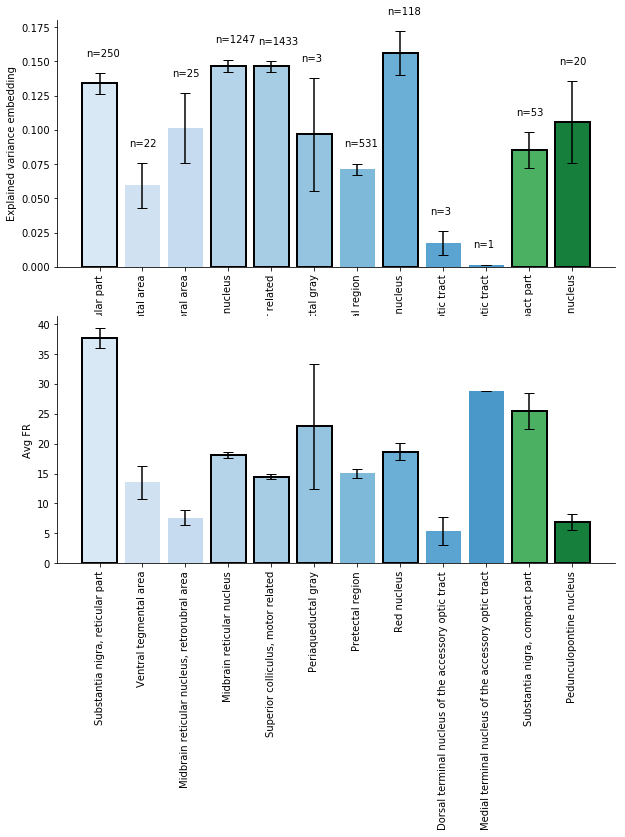

In [105]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)

def get_mean_and_sem_for_subregions(r2, inds, subregions):
    m = np.zeros(len(subregions))
    sem = np.zeros(len(subregions))
    for idx, sub_region_label in enumerate(subregions):
        m[idx] = np.mean(r2[inds[subregions[idx]]])
        sem[idx] = np.std(r2[inds[subregions[idx]]]) \
            /np.sqrt(r2[inds[subregions[idx]]].shape[0])
    return m, sem

m, sem = get_mean_and_sem_for_subregions(r2, joint_inds, use_midbrain_nuclei)

def plot_barplot_with_sem(ax, m, sem, color_list, xticklabels,ylabel, n_neurons_list = None, highlight = None):
    
    ax.bar(np.arange(0,len(m)),m, color = color_list, \
           yerr=sem, align='center', ecolor='black', capsize=5)
    if highlight is not None:
        ax.bar(np.arange(0,len(m))[highlight],m[highlight], color = np.array(color_list)[highlight], \
              align='center', edgecolor='black', linewidth=2)
    
    _ = ax.set_xticks(np.arange(0,len(m)))
    _ = ax.set_xticklabels(xticklabels, rotation = 90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    _ = ax.set_ylabel(ylabel)
    if n_neurons_list is not None:
        for i in range(len(n_neurons_list)):
            ax.text(i-0.3, m[i] + sem[i] + 0.3 * max(sem), 'n=%d' % n_neurons_list[i], fontsize=10, color='black')
    return ax

_ = plot_barplot_with_sem(ax_bar, m, sem, joint_color_list, use_midbrain_nuclei, 'Explained variance embedding', neuron_count, highlight_mask)

ax_bar = f.add_subplot(2,1,2)

m_fr, sem_fr = get_mean_and_sem_for_subregions(mat['fr'], joint_inds, use_midbrain_nuclei)

_ = plot_barplot_with_sem(ax_bar, m_fr, sem_fr, joint_color_list, use_midbrain_nuclei, 'Avg FR', highlight=highlight_mask)
